# Paired guide similarity analysis

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import scipy.stats as stats
import sklearn.linear_model as lm
import sklearn.metrics as metrics
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
data_path = '/mnt/c/Users/minch/Data/bmdc/'

### Define the models to be studied

For each model, specify the path to the regression outputs

In [10]:
models = {
    'Base':'analysis/beta_null.csv',
    'PCA_5':'analysis/beta_0_0.csv',
    'VAE_128_5':'analysis/beta_128_5.csv',
}

### Paired guides

In [22]:
detailed_results = []
results = []
for name, path in models.items():
    
    coefs_df = pd.read_csv(data_path + path, index_col=0)
    guide_list = coefs_df.columns.tolist()
    
    # Get a list of guides that have an effect
    sig_guide_list = coefs_df.columns[coefs_df.max(axis=0) > 0.15]
    sig_guide_genes = [x.split('_')[1] for x in sig_guide_list]
    
    # Generate combinations of guides
    guide_pairs = pd.DataFrame(itertools.combinations(guide_list, 2),columns=['guide1', 'guide2'])
    guide_pairs['target_gene_1'] = guide_pairs['guide1'].str.split('_').str[1]
    guide_pairs['target_gene_2'] = guide_pairs['guide2'].str.split('_').str[1]
    guide_pairs['paired'] = guide_pairs['target_gene_1'] == guide_pairs['target_gene_2']
    guide_pairs['sig'] = guide_pairs['target_gene_1'].isin(sig_guide_genes) & guide_pairs['target_gene_2'].isin(sig_guide_genes)
    
    # A pair is a positive control if it's targeting same gene and it has an effect
    guide_pairs['pos_ctrl'] = guide_pairs['paired'] & guide_pairs['sig']
    
    # Compute correlations
    guide_pairs['beta_corr'] = [stats.spearmanr(coefs_df[row['guide1']], coefs_df[row['guide2']])[0] for idx, row in guide_pairs.iterrows()]
    guide_pairs['method'] = name
    
    detailed_results.append(guide_pairs)
    ks_stat, ks_pval = stats.ks_2samp( 
        guide_pairs.query('~pos_ctrl').beta_corr,
        guide_pairs.query('pos_ctrl').beta_corr)
    results.append((name, ks_stat, ks_pval))
    
detailed_results = pd.concat(detailed_results)
results = pd.DataFrame(results, columns=['method', 'ks_stat', 'ks_pval'])

In [28]:
detailed_results.groupby(['method', 'pos_ctrl'])['beta_corr'].mean()

method     pos_ctrl
Base       False       0.002709
           True        0.014929
PCA_5      False       0.002485
           True        0.014009
VAE_128_5  False       0.002496
           True        0.015292
Name: beta_corr, dtype: float64

In [26]:
detailed_results.groupby(['method', 'pos_ctrl'])

<Axes: xlabel='method', ylabel='beta_corr'>

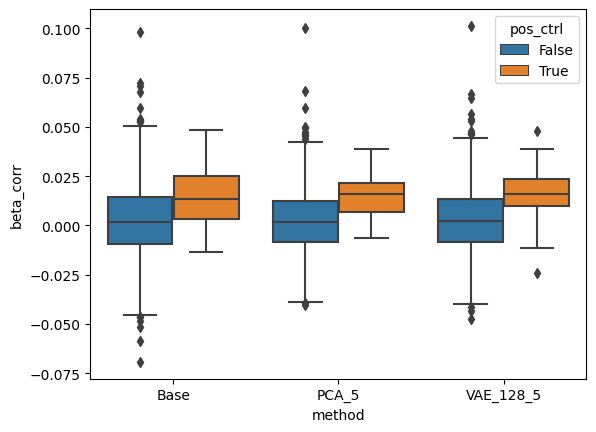

In [23]:
sns.boxplot(x='method', y='beta_corr', hue='pos_ctrl', data=detailed_results)

In [24]:
results

,method,ks_stat,ks_pval
0,Base,0.359414,0.002365
1,PCA_5,0.417747,0.000210
2,VAE_128_5,0.488506,0.000027
